In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 100
problem_spec['translation'] = "b"
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_spec['sc_theta'] = 2

problem_data['rho'] = 1.
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 100, 'translation': 'b'}


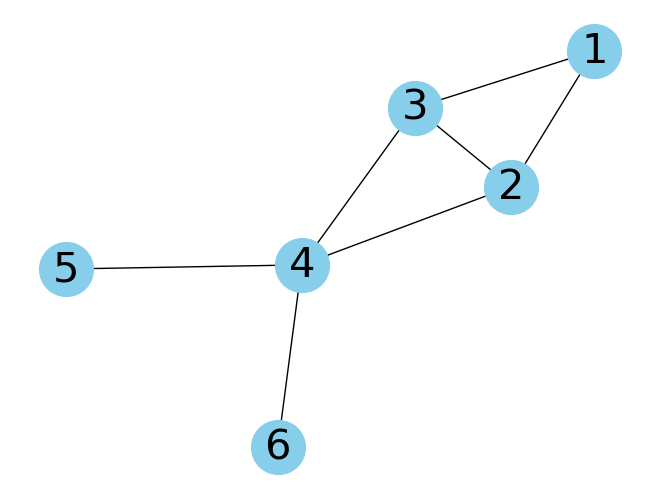

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=2722846.538729745, np.linalg.norm(x_opt_star)=1902.366221063773


In [5]:
b = problem_data['b']
c = problem_data['c']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
theta = problem_spec['sc_theta']
prox_operators = []
fi_operators = []

for jj in range(n_node):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    cj = c[jj*vector_size : (jj+1)*vector_size]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, cj=cj:  prox_fj_geom_mean_sc(z, rho, bj, cj, theta=theta)]
        fi_operators += [lambda x_kj, bj=bj, cj=cj: np.linalg.norm((x_kj - bj), ord=2) + theta*np.linalg.norm(x_kj - cj, ord=2)**2]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, cj, theta=theta)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, cj, vector_size, theta=theta)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-3

In [6]:
R = 0.6
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.569912859956493, err_opt_reldiff[-1]=0.9309799656005475
ii=200, f_reldiff[-1]=3.3800398044627485e-12, err_opt_reldiff[-1]=1.9538535747828037e-06
ii=400, f_reldiff[-1]=3.3844863251526913e-12, err_opt_reldiff[-1]=1.9538535704158423e-06
ii=600, f_reldiff[-1]=3.3846573451792277e-12, err_opt_reldiff[-1]=1.9538535704298107e-06
ii=800, f_reldiff[-1]=3.3846573451792277e-12, err_opt_reldiff[-1]=1.9538535704539194e-06
ii=999, f_reldiff[-1]=3.3846573451792277e-12, err_opt_reldiff[-1]=1.9538535704518035e-06


In [7]:
# apply P-EXTRA 
problem_data['rho'] = 1
pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9647314744907467, err_opt_reldiff[-1]=0.7325183221383035
ii=200, f_reldiff[-1]=7.962711248227392e-05, err_opt_reldiff[-1]=2.5435726352083494e-05
ii=400, f_reldiff[-1]=3.1786144694486534e-09, err_opt_reldiff[-1]=1.2180743801772527e-06
ii=600, f_reldiff[-1]=3.5130933851079628e-12, err_opt_reldiff[-1]=1.2176052047711073e-06
ii=800, f_reldiff[-1]=3.3865385654711267e-12, err_opt_reldiff[-1]=1.2176051893952237e-06
ii=999, f_reldiff[-1]=3.3865385654711267e-12, err_opt_reldiff[-1]=1.217605189644277e-06


In [8]:
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.51541700023903}
params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.5180363325273216}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.6716255892091836, err_opt_reldiff[-1]=0.9355364642949204
ii=200, f_reldiff[-1]=3.3846573451792277e-12, err_opt_reldiff[-1]=1.953853570259935e-06
ii=400, f_reldiff[-1]=3.3846573451792277e-12, err_opt_reldiff[-1]=1.9538535702915025e-06
ii=600, f_reldiff[-1]=3.384828365205764e-12, err_opt_reldiff[-1]=1.953853570283186e-06
ii=800, f_reldiff[-1]=3.384828365205764e-12, err_opt_reldiff[-1]=1.9538535703002007e-06
ii=999, f_reldiff[-1]=3.3846573451792277e-12, err_opt_reldiff[-1]=1.953853570286996e-06


In [9]:
fname = "n6_circuit_dadmm_c_theta%s"%str(problem_spec['sc_theta'])

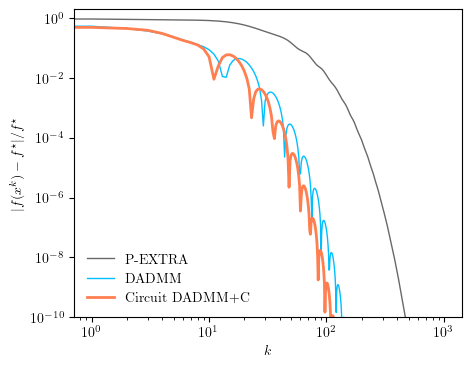

In [10]:
T = 1000
co.plot_methods([pg_f_reldiff[:T] ,admm_f_reldiff[:T], dadmm_c_f_reldiff[:T]],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-10, 2e-0, fname)

In [11]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-10)[0][0]

109

In [12]:
np.where(np.array(admm_f_reldiff) < 1e-10)[0][0]

135

In [13]:
np.where(np.array(pg_f_reldiff) < 1e-10)[0][0]

469